<a href="https://colab.research.google.com/github/knight19720208ui/AI/blob/main/Taxi_openAI_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aprendizaje por refuerzo - Inteligencia Artificial 
Tomado de: **: Ing. Ana Laura Diedrichs**

# Introducción

Vamos a trabajar utilizando este notebook y una librería llamada OpenAI (https://gym.openai.com/) y realizaremos simulaciones de aprendizaje por refuerzo.

Ejecute los siguientes dos bloques de código (click en la flechita a la izquierda del bloque de código).

Primero instalamos las librerías necesarias necesarias.

In [ ]:
!pip install cmake 'gym' scipy

In [ ]:
# este es un comentario en el código
import gym # importa librería gym
import pandas as pd # carga la librería pandas y la llamaremos como pd
import matplotlib.pyplot as plt # carga la librería pyplot y la llamaremos de forma abreviada como plt



## Descripción del ambiente


El siguiente bloque de código crea el ambiente **Taxi**, del inglés *environment* y su abreviatura *env*.


In [ ]:
env = gym.make("Taxi-v2").env # crea / instancia ambiente llamado Taxi-v2

env.render() # nos muestra una imagen de como luce el ambiente.


* El trabajo del agente es recoger un pasajero de una ubicación y llevarlo a un destino. 
* Se reciben +20 puntos por llevarlo al destino indicado y se pierte un punto por cada paso realizado (*time-step*)
* Se penaliza con 10 puntos (-10) por intentar recoger un pasajero o dejarlo en un destino que no era el indicado.
* El cuadradito relleno de amarillo representa el taxi cuando no lleva pasajeros y se pone verde cuando lleva un pasajero.
* El *pipe* (símbolo | ) representa una pared o muro, la misma no puede ser atravesada por el taxi.
* Hay cuatro (4) ubicaciones idenficadas con distintas letras. 

R, G, Y, B  son posibles destino de recogida y llegada/destino de pasajeros. 

La letra en azul representa una ubicación actual para recoger un pasajero, y la letra lila o púrpura representa el destino del pasajero.



Veamos que otras cosas podemos hacer con *environment*

In [ ]:
env.reset() # me "resetea" el ambiente a uno nuevo, uno aleatorio
env.render() # muestra la imagen del ambiente

print("Action Space {}".format(env.action_space)) # cuántas acciones puede tomar el agente
print("State Space {}".format(env.observation_space)) # cuántos espacios o estados s puede tomar el agente


Como nos muestra la salida del *print* tenemos un espacio de acción de tamaño 6 (seis) y un espacio de estados de tamaño 500. 

Los 500 estados posibles corresponden a la codificación que incluye: ubicación del taxi, ubicación del pasajero y ubicación destino del pasajero. (ver actividad nro 2))

Nuestro algoritmo de aprendizaje por refuerzo (RL) no necesita más que estas dos cosas: el conjunto de acciones posibles y el conjunto de estados posibles. 

Necesitamos identificar cada estado de forma unívoca, asignándole un número único al estado (un ID) y que el algortimo RL elija algunas de las acciones posibles a tomar, que están etiquetadas desde el 0 cero al 5 cinco, donde:


* 0 = sur
* 1 = nore
* 2 = este
* 3 = oeste
* 4 = *pickup* o recoger pasajero
* 5 = *dropoff* o dejar en su destino al pasajero


En cada unidad de tiempo discreta de nuestro simulador, según una acción ejecutada sobre el ambiente, el mismo regresa los siguientes elementos:

In [ ]:
env.step(3)

* **Observación**  (objecto): el estado del ambiente o un objeto específico del ambiente que representa la observación del mismo.
* **Recompensa** o Reward (float): es la recompensa alcanzada por la acción previa.

* **Done** (boolean): si es momento de "resetear el ambiente". La mayoría de las tareas en varios ambientes si el valor done = True indica que el episodio ha terminado (perdiste una vida en un video juego, por ejemplo) o se alcanzó un objetivo (dejamos pasajero en su destino, para este ejemplo).
* **Info** (dict): podemos ignorar este atributo, brinda información de diagnóstico para debugging. No hay que usar nada de esto para aprendizaje/entrenamiento.

#### [ACTIVIDAD] Detalle cuáles son los valores de recompensa para este problema

Vea la [info del entorno](https://gym.openai.com/envs/Taxi-v2/)

RESPUESTA

Se otorga una recompensa de 20 puntos cada vez que deja a un pasajero en la ubicacion correcta (dropoff).
Se otorga una penalización de 1 punto por cada paso que hace para dejar un pasajero, y una penalizacion de 10 puntos por cada accion de pickup o dropoff invalida. 

Veamos como está codificado el estado y el ambiente del Taxi.

In [ ]:
state = env.encode(3, 1, 1, 0) # (fila de posición del taxi, columna de posición del taxi, índice del pasajero, índice del destino)
print("State:", state)

env.s = state
env.render()

#### **[ACTIVIDAD]** Modifique la primer línea del siguiente script para ver dónde es la posición (3,4) del mapa y la (0,0)


In [ ]:
# posición dle taxi en 0,0
state = env.encode(0, 0, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state) # muestra el número de estado, una codificación.

env.s = state
env.render() # nos muestra una representación gráfica del estado.

In [ ]:
# posición del taxi en 3,4 (es decir cuarta fila y quinta columna, ya que empieza en 0,0 )

state = env.encode(3, 4, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state) # muestra el número de estado, una codificación.

env.s = state
env.render() # nos muestra una representación gráfica del estado.

**[ACTIVIDAD]** Modifique el siguiente script, verifique cuáles son los valores posibles de los índices de pasajero y destino. ¿Qué representan.?

In [ ]:
state = env.encode(1, 1, 0, 3)# (fila de posición del taxi, columna de posición del taxi, índice del pasajero, índice del destino)
print("State:", state)
env.s = state
env.render()

Los valores del indice de pasajero pueden tomar un valor den 0 al 4, que indica cada una de las 5 posiciones en las que puede estar el pasajero, que son R,G,Y,B y arriba del taxi.
El indice destino puede tomar un valor del 0 al 3, donde 0 = R, 1 = G,  2= Y, 3= B
por lo tanto se indica el destino del pasajero 

## Comportamiento del agente aleatorio (random search)

Ejecute el siguiente bloque de código

In [ ]:
env.s = 329  # estado desde el cual arranca. 

#### **[ACTIVIDAD]**  Visualice el estado. Reutilice código anterior.

In [ ]:
# coloque aquí el código y ejecute
env.render()

Inicializamos variables


In [ ]:
epochs = 0 # contador de iteraciones
penalties, reward = 0, 0 # penalidades y recompensas
frames = [] # para la animación 
rewards = [] # guardamos la recompensa obtenida por cada acción
done = False

El siguiente código muestra la ejecución de un agente de búsqueda aleatoria.




In [ ]:
# mientras no llegue al objetivo
while not done:
    action = env.action_space.sample() # elige la próxima acción de forma aleatoria
    state, reward, done, info = env.step(action) # se ejecuta la acción sobre el ambiente

    if reward == -10:  # si lo penalizan, suma una penalización.
        penalties += 1
    
    rewards.append({'epoch':epochs,'reward':reward}) #guarda el nro de iteración y valor de recompensa obtenida.
    
    # Guarda información de cada frame en un diccionario, para posterior animación
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1 # incrementa número de iteración
    
    
print("Cuantos pasos o epochs o time-steps corrió: {}".format(epochs))
print("Penalidades (cuántas veces fue penalizado): {}".format(penalties))

A continuación visualizamos esas recompensas otorgadas por cada episodio de ejecución del agente.

In [ ]:
df = pd.DataFrame(rewards)

plt.plot(df['reward'])
# agregue título al gráfico
plt.title("Recompensa otorgadada en cada paso")
# agregue etiqueta al eje x y al eje y
plt.xlabel("Paso")
plt.ylabel("Recompensa")


#### **[ACTIVIDAD]** 

Agregue título al gráfico anterior y etiqueta a los ejes x e y usando las funciones de matplotlib usando las funciones 

* xlabel("Nombre del eje x")
* ylabel("Nombre del eje y")
* title("Título del gráfico")


El siguiente gráfico muestra la suma acumulada de las recompensas a través del tiempo. Observamos claramente una tendencia negativa, pues el agente ha sido penalizado (recompensa negativa) la mayor parte del tiempo.

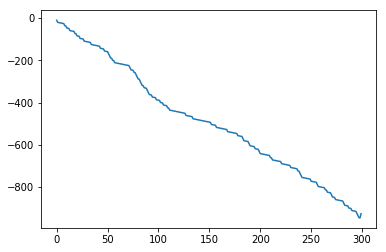

In [ ]:
plt.plot(df['reward'].cumsum())

Ejecute el siguiente bloque para observar las acciones del agente y el ambiente

In [ ]:
from IPython.display import clear_output
from time import sleep

# función print_frames
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
# print_frames(frames) # descomente para llamar a la función print_frames o utilice un bloque de código aparte.

Para nada bueno el desempeño del agente. A nuestro agente aleatorio le toma miles de *timesteps* o *epochs* cometiendo muchas acciones erróneas (es penalizado muchas veces) para tan sólo acercar a un pasajero al destino.



## Aprendizaje por refuerzo con Q-learning



Inicializamos tabla Q con ceros.

In [ ]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Entrenamos al agente, es decir, *completamos* la tabla Q con valores que se ajusten a una política.

**Hiperparámetros**

$\alpha$ es el coeficiente de aprendizaje en Q-learning, página 873 del libro

$\gamma$ el factor de descuento 

$\epsilon$ ¿para qué usamos este coeficiente en el código.





Observe las líneas 24 a la 27 y responda la actividad 2) 


## [Algoritmo Q-Learning](https://es.wikipedia.org/wiki/Q-learning)

![alt](https://wikimedia.org/api/rest_v1/media/math/render/svg/59db58edf1222b292e40706e503ed5974553606b)

In [ ]:
%%time
"""Entrenando el agente"""

import random
from IPython.display import clear_output

# Hiperparámetros
alpha = 0.1 # tasa de aprendizaje en Q-learning
gamma = 0.6 # factor de descuento gamma,
epsilon = 0.1 # probabilidad 
max_iter = 10000 #100001
# para graficar métricas
all_epochs = []
all_penalties = []
rewards = []

for i in range(1, max_iter):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() 
        else:
            action = np.argmax(q_table[state]) 

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        
        next_max = np.max(q_table[next_state])
        
        #new_value =  old_value + alpha * (old_value- reward - gamma * next_max)
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
            
        rewards.append({'epoch':epochs,'reward':reward})
        
        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 9900
Training finished.

CPU times: user 4.87 s, sys: 259 ms, total: 5.12 s
Wall time: 5.01 s


## Evaluemos el agente



Dada la tabla Q aprendida, la ponemos a prueba en el ambiente.

Política óptima:

$\pi^{*}(s) = arg max_a Q(s,a)$

In [ ]:

total_epochs, total_penalties = 0, 0
episodes = 5
rewards3 = []
frames = [] # para la animación

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done: # mientras el taxi no llegue a destino.
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1
        rewards3.append({'epoch':epochs,'reward':reward})
        
        # frames para animacion
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )

    total_penalties += penalties
    total_epochs += epochs

print(f"Resultados luego de  {episodes} episodios:")
print(f"Promedio de timestemps o iteraciones por episodio: {total_epochs / episodes}")
print(f"Promedio de penalidades por episodio: {total_penalties / episodes}")

Resultados luego de  5 episodios:
Promedio de timestemps o iteraciones por episodio: 13.2
Promedio de penalidades por episodio: 0.0


Ejecute el siguiente bloque de código si desea visualizar las acciones ejecutadas por el agente. 
**Nota**: puede demorar un poco.


In [ ]:
# print_frames(frames)

#### [ACTIVIDAD] Grafique la suma acumulada de recompensas a través del tiempo (epochs)

Text(0, 0.5, 'Recompensa')

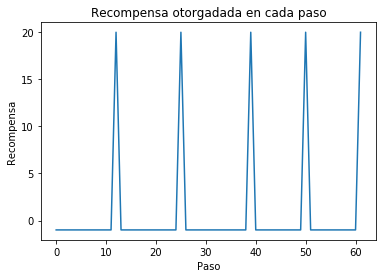

In [ ]:
df = pd.DataFrame(rewards3)

plt.plot(df['reward'])
# agregue título al gráfico
plt.title("Recompensa otorgadada en cada paso")
# agregue etiqueta al eje x y al eje y
plt.xlabel("Paso")
plt.ylabel("Recompensa")

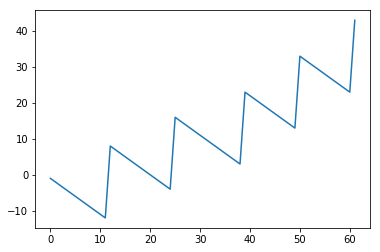

In [ ]:
plt.plot(df['reward'].cumsum())

# ACTIVIDADES

## 1) Explique, detalle, como se calcula los 500 estados posibles del problema del *Taxi*. Desglose cada término y valor implicado.

**ESCRIBA AQUI SU RESPUESTA A LA CONSIGNA**

Existen 500 estados que es el resultado de multiplicar 5 filas * 5 columnas * 5 posiciones de la persona * 4 destinos posibles. 

Cada estado se calcula de la siguiente manera: 


def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):

        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
        
 Taxi row y col son las representan la fila y columna (del 0 al 4) en las que puede estar ubicado el taxi. 
 pass_loc es la ubicacion donde se encuentra el pasajero, son 4 los posibles valores que toma (del 0 al 4)
 dest_idx es la ubicacion de destino a la que quiere ir el pasajero, tambien toma un valor del 0 al 3. 
 




## 2) En el código de Q-learning presentado. 

2.1 Explique que hace las líneas de código entre 24 -27 . Pista: explorar vs explotar.




2.2 ¿Qué pasaría si el valor de $ \epsilon $ fuera 1?





## 3.1) Basado en los resultados anteriores, indique cuál agente funcionó mejor (aleatorio vs Q-learning) y justifique.



**ESCRIBA AQUI SU TEXTO DE RESPUESTA A LA CONSIGNA 

El funcionamiento con q-learning es mucho mejor que el aleatorio. En el aleatorio se obtienen muchas mas recompensas negativas ya que simplemente elige acciones al azar y eso genera un rendimiento muy pobre.


En cambio cuando usamos q-learning en cada episodio se pudo llevar al pasajero a su destino de manera mas eficiente y se obtuvieron recompensas positivas. 

## 3.2) Compare para este entorno el desempeño y funcionamiento de iteración de valores y políticas vs Q-learning. Utilice código del laboratorio anterior. Escriba sus conclusiones, mientras más completas, mejor.

### Iteración de valores

In [ ]:
def one_step_lookahead(env, state, V , discount_factor = 0.99):
    """
    Función ayuda o auxiliar para calcular estado-valor 
    
    Arguments:
        env: objeto del ambiente openAI GYM 
        state: estado a considerar
        V: valor estimado para cada estado. Vector de longitud nS.
        discount_factor: factor de descuento MDP.
        
    Return:
        action_values: Valor esperado por cada acción en un estado. Vector de longitud nA
    """
    
    # inicitaliza el vector de valores d acciones
    action_values = np.zeros(env.nA)
    
    # itera sobre las acciones que podemos tomar del ambiente
    for action in range(env.nA):
        # itera sobre la distribución P_sa (probabilidad estado/acción)
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))
            
    return action_values

In [ ]:
def update_policy(env, policy, V, discount_factor):
    
    """
    Helper function to update a given policy based on given value function.
      
    
    Arguments:
        env: objeto del ambiente openAI GYM 
        state: estado a considerar
        V: valor estimado para cada estado. Vector de longitud nS.
        discount_factor: factor de descuento MDP.
    Return:
        policy: Política actualizada basada en la función estado-Valor o estado-Utilidad 'V'.
    """
    
    for state in range(env.nS):
        # Dado un estado, computar el valor estado-acción.
        action_values = one_step_lookahead(env, state, V, discount_factor)
        
        # elige una acción que maximice el valor de utilidad de estado-acción.
        policy[state] =  np.argmax(action_values)
        
    return policy

In [ ]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize value fucntion
    V = np.zeros(env.nS)
    
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_v = np.copy(V) 
    
        # loop over all states
        for state in range(env.nS):
            
            # Asynchronously update the state-action value
            #action_values = one_step_lookahead(env, state, V, discount_factor)
            
            # Synchronously update the state-action value
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)
            
            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            V[state] =  best_action_value
            
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return V, optimal_policy


In [ ]:
def policy_eval(env, policy, V, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to evaluate.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state following a given policy and state-value 'V'. 
        
    """
    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [ ]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        new_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize the state-Value function
    V = np.zeros(env.nS)
    
    # intialize a random policy
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)
    
    for i in range(max_iteration):
        
        # evaluate given policy
        V = policy_eval(env, policy, V, discount_factor)
        
        # improve policy
        policy = update_policy(env, policy, V, discount_factor)
        
        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)
            

            
    return V, policy

In [ ]:
import time

In [ ]:
env = gym.make("Taxi-v2")
tic = time.time()
opt_V, opt_Policy = value_iteration(env.env, max_iteration = 1000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ') # Utilidad


Time to converge:  6.63e+03 ms
Optimal Value function: 


Inicializamos variables


In [ ]:
epochs = 0 # contador de iteraciones
penalties, reward = 0, 0 # penalidades y recompensas
frames = [] # para la animación 
rewards4 = [] # guardamos la recompensa obtenida por cada acción
done = False

El siguiente código muestra la ejecución de un agente de búsqueda aleatoria.




In [ ]:
def choose_action(observation):
  return opt_Policy[observation] 


state=env.reset()
# mientras no llegue al objetivo
while not done:
    action = choose_action(state) # elige la próxima acción de forma aleatoria
    state, reward, done, info = env.step(action) # se ejecuta la acción sobre el ambiente

    if reward == -10:  # si lo penalizan, suma una penalización.
        penalties += 1
    
    rewards4.append({'epoch':epochs,'reward':reward}) #guarda el nro de iteración y valor de recompensa obtenida.
    
    # Guarda información de cada frame en un diccionario, para posterior animación
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1 # incrementa número de iteración
    
    
print("Cuantos pasos o epochs o time-steps corrió: {}".format(epochs))
print("Penalidades (cuántas veces fue penalizado): {}".format(penalties))

Cuantos pasos o epochs o time-steps corrió: 12
Penalidades (cuántas veces fue penalizado): 0


Evaluacion de la recompensa en el tiempo de la recompensa

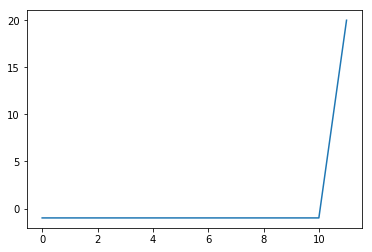

In [ ]:
df = pd.DataFrame(rewards4)
# variacion de los valores por cada iteracion
plt.plot(df['reward'])


Recompensa acumulada

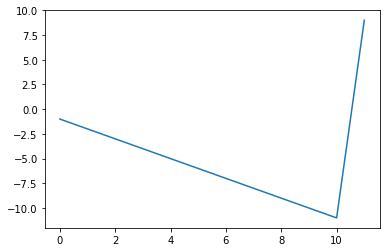

In [ ]:
# recompensa acumulada
plt.plot(df['reward'].cumsum())

In [ ]:
enviroment2 = gym.make("Taxi-v2")
tic = time.time()
opt_V2, opt_policy2 = policy_iteration(enviroment2.env, discount_factor = 0.999, max_iteration = 10000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Tiempo para converger: {elapsed_time: 0.3} ms")
print('Función de valores/utilidades óptima: ')

policy converged at iteration 31
Tiempo para converger:  1.72e+02 ms
Función de valores/utilidades óptima: 


Inicializamos variables


In [ ]:
epochs = 0 # contador de iteraciones
penalties, reward = 0, 0 # penalidades y recompensas
frames = [] # para la animación 
rewards4 = [] # guardamos la recompensa obtenida por cada acción
done = False

El siguiente código muestra la ejecución de un agente de búsqueda aleatoria.




In [ ]:
def choose_action(observation):
  return opt_policy2[observation] 


state=enviroment2.reset()
# mientras no llegue al objetivo
while not done:
    action = choose_action(state) # elige la próxima acción de forma aleatoria
    state, reward, done, info = env.step(action) # se ejecuta la acción sobre el ambiente

    if reward == -10:  # si lo penalizan, suma una penalización.
        penalties += 1
    
    rewards4.append({'epoch':epochs,'reward':reward}) #guarda el nro de iteración y valor de recompensa obtenida.
    
    # Guarda información de cada frame en un diccionario, para posterior animación
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1 # incrementa número de iteración
    
    
print("Cuantos pasos o epochs o time-steps corrió: {}".format(epochs))
print("Penalidades (cuántas veces fue penalizado): {}".format(penalties))

Cuantos pasos o epochs o time-steps corrió: 4
Penalidades (cuántas veces fue penalizado): 0


Evaluacion de la recompensa en el tiempo de la recompensa

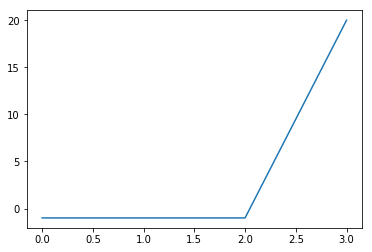

In [ ]:
df = pd.DataFrame(rewards4)
# variacion de los valores por cada iteracion
plt.plot(df['reward'])


Recompensa acumulada

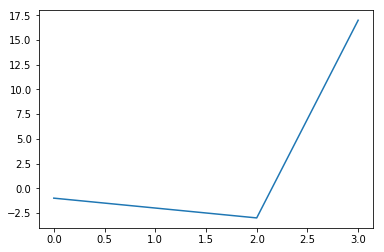

In [ ]:
# recompensa acumulada
plt.plot(df['reward'].cumsum())

### Conclusiones

Podemos concluir que el algoritmo de q-learning obtiene muy buenos resultados aunque consume mucho tiempo, y a veces cuando probamos con muchos escenarios, los tiempos de ejecución son muy altos y no llega a una solución rapidamente. Los algoritmos de iteración de valores mostraron un buen rendimiento y eficiencia, pero el de iteración de politicas requirio menos tiempo y pasos para llegar al objetivo. 

## [ OPCIONAL ] 4) Búsqueda en grilla

Realice una búsqueda en grilla para determinar los mejores valores para alpha, gamma y epsilon, entre los valores siguientes valores.


Valores de alpha a considerar: {0.1, 0.3 ,0.6}

Valores de gamma a considerar:  {0.1,0.5, 0.9}

Valores de epsilon a considerar: {0.1,0.5, 0.9}


* Cree el script para ejecutar este experimento.

* Determine los valores de rendimiento a guardar de cada experimento (recompensa promedio, penalización promedio, etc)

* Utilice la cantidad de bloques de código y texto que crea necesarios



# Referencias

Este laboratorio fue inspirado gracias a las siguientes referencias:

* Open AI Gym (https://gym.openai.com/)
* Taxi environment in Open AI Gym 
 * https://gym.openai.com/envs/Taxi-v2/
 * https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
* Q-learning from scratch https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
* Q-learning, wikipedia https://es.wikipedia.org/wiki/Q-learning

